In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 워닝 무시
import warnings
warnings.filterwarnings('ignore')

In [23]:
df_ins = pd.read_csv("data/insurance.csv")

print(df_ins.shape)
df_ins.head()

(1353, 9)


,age,sex,bmi,children,smoker,region,charges,ins_type,period
0,18,male,53.13,0,no,southeast,1163.4627,A,7.4
1,22,male,52.58,1,yes,southeast,44501.3982,B,6.5
2,23,male,50.38,1,no,southeast,2438.0552,C,4.5
3,58,male,49.06,0,no,southeast,11381.3254,B,6.6
4,46,female,48.07,2,no,northeast,9432.9253,C,4.0


# 데이터 분리

In [24]:
# 범주형 변수 수치화(원핫 인코딩)
#drop_first=True 는 원-핫 인코딩(One-Hot Encoding) 할 때 👉 첫 번째 범주(category)를 하나 제거한다는 뜻이야.
df_dummies = pd.get_dummies(df_ins, dtype='int', drop_first=True)
df_dummies

,age,bmi,children,charges,period,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,ins_type_B,ins_type_C
0,18,53.130,0,1163.46270,7.4,1,0,0,1,0,0,0
1,22,52.580,1,44501.39820,6.5,1,1,0,1,0,1,0
2,23,50.380,1,2438.05520,4.5,1,0,0,1,0,0,1
3,58,49.060,0,11381.32540,6.6,1,0,0,1,0,1,0
4,46,48.070,2,9432.92530,4.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1348,28,17.290,0,3732.62510,3.4,0,0,0,0,0,0,1
1349,26,17.195,2,14455.64405,3.5,0,1,0,0,0,0,1
1350,21,16.815,1,3167.45585,2.2,0,0,0,0,0,0,1
1351,38,16.815,2,6640.54485,4.1,1,0,0,0,0,1,0


In [25]:
x = df_dummies.drop(columns=['charges'])
y = df_dummies['charges']

In [26]:
#👉 데이터를 훈련용(train)과 테스트용(test)으로 나누기 위해 train_test_split 함수를 불러오는 코드야.
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=100)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(947, 11)
(406, 11)
(947,)
(406,)


# 랜덤포레스트 회귀 모델링 w. GridSearchCV

In [27]:
from sklearn.ensemble import RandomForestRegressor  # 랜덤포레스트 회귀 
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=100)

In [28]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 3, 5]
}

In [29]:
grid = GridSearchCV(
    rf,           # 랜덤포레스트 회귀 모델 
    param_grid,
    cv=5,         # 교차검증 횟수
    scoring='neg_root_mean_squared_error',    # 회귀에서는 RMSE 기준
    n_jobs=-1,
    verbose=1     # 학습 과정에 대한 정보량 
)

In [30]:
%%time
grid.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 15.7 μs


NameError: name 'X_train' is not defined

In [18]:
# 그리드서치 결과
results = pd.DataFrame(grid.cv_results_)

# 주요 컬럼만 보기
cols = [
    'params',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

results[cols].sort_values('rank_test_score').head(10)

,params,mean_test_score,std_test_score,rank_test_score
2,"{'max_depth': 5, 'n_estimators': 300}",-5526.075939,276.896553,1
1,"{'max_depth': 5, 'n_estimators': 200}",-5539.907060,270.527084,2
0,"{'max_depth': 5, 'n_estimators': 100}",-5552.411129,273.465404,3
5,"{'max_depth': 10, 'n_estimators': 300}",-5598.859139,272.715836,4
4,"{'max_depth': 10, 'n_estimators': 200}",-5613.344266,265.783145,5
8,"{'max_depth': 20, 'n_estimators': 300}",-5613.368600,265.647973,6
3,"{'max_depth': 10, 'n_estimators': 100}",-5615.096039,260.865231,7
7,"{'max_depth': 20, 'n_estimators': 200}",-5619.710818,258.020542,8
6,"{'max_depth': 20, 'n_estimators': 100}",-5648.937126,248.545627,9


In [19]:
# best 모델 
best_model = grid.best_estimator_
best_model

RandomForestRegressor(max_depth=5, n_estimators=300, random_state=100)

In [23]:
y_pred = best_model.predict(x_test)

In [26]:
# 평가지표 
from sklearn.metrics import r2_score, mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(rmse, r2)

4956.927436326148 0.8529251589207989


In [ ]:
# 과거 선형회귀 모델보다 랜덤포레스트 회귀 모델이 r2 기준 성능이 더 좋다.

# 중요 변수 파악

In [29]:
importances = best_model.feature_importances_

feat_imp = pd.DataFrame({
    'feature': x_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_imp)

             feature  importance
5         smoker_yes    0.663170
1                bmi    0.154301
0                age    0.132994
3             period    0.017298
7   region_southeast    0.016457
2           children    0.011015
4           sex_male    0.001174
6   region_northwest    0.001063
10        ins_type_C    0.000999
9         ins_type_B    0.000945
8   region_southwest    0.000584


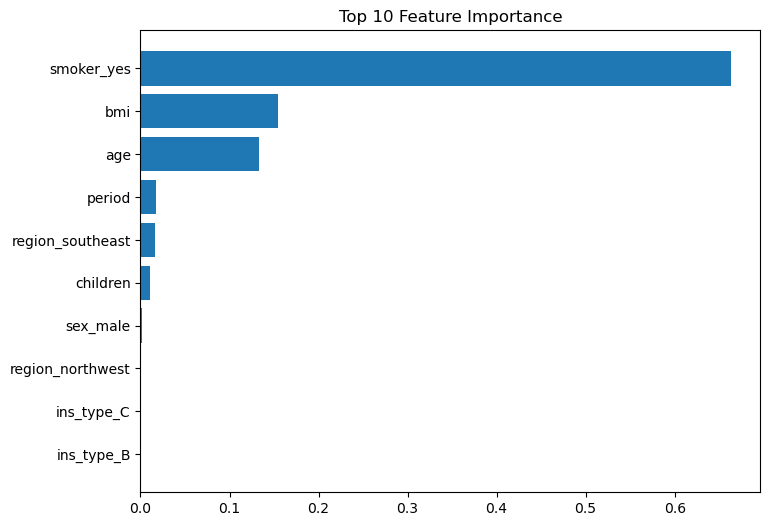

In [30]:
# 상위 10개 시각화
plt.figure(figsize=(8,6))
plt.barh(feat_imp['feature'][:10], feat_imp['importance'][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importance")
plt.show()